# Stream fit

### The stream is modelled with a segment of the orbit. The potential is kept fixed. The optimization is among the initial conditions of the stream progenitor.


In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize
from scipy import interpolate
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import config as cfg
from galpy.potential.mwpotentials import MWPotential2014
from galpy.potential import plotRotcurve
import pandas as pd
%load_ext autoreload
%autoreload 2

## The orbit model
The orbit should be integrated backwards and forwards during a given time span.

In [2]:
# Mass and density profile (RAR)

import model_def    

# Rar model evaluation
ener_f = 56.0  # keV
param = np.array([ener_f, 3.77780827e+01, 6.63468885e+01, 1.20446329e-05])  # 
r_mw,mass_mw = model_def.model(param)
rho_mw = np.diff(mass_mw)/np.diff(r_mw)/(4.0*np.pi*r_mw[:-1]**2)  # M_sun/pc^3

# Interpolation avoiding NANs
k = np.argwhere(np.isnan(mass_mw))[0][0]
r_sh = r_mw[0:k]
mass_sh = mass_mw[0:k]
cfg.r_max_mw=r_sh[-1]

cfg.mass_spline = InterpolatedUnivariateSpline(r_sh,mass_sh,k=4)  # Allows easy computation of derivatives
def rho_spline(r) :
    deriv= mass_spline.derivative(1)
    return deriv(r)/(4.0*np.pi*r*r)



r_0= 2.610874926720639e-18
r_f= 2343.7400960101527
t_0= -22.917913528839406
R= 72320262676055.66
37.7780827 66.3468885 1.20446329e-05
/home/mmestre/work/2020/halostream/sources/stream_fit/fixed_pot/orbit_model/model_def.py:25: RuntimeWarning: invalid value encountered in sqrt
  return eps*eps*np.sqrt(eps*eps-1.0)*fermi(eps,alpha_r,beta_r,eps_r)

/home/mmestre/work/2020/halostream/sources/stream_fit/fixed_pot/orbit_model/model_def.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eps*eps-1.0)**3*fermi(eps,alpha_r,beta_r,eps_r)



In [5]:
# Gravitational acceleration


import accelerations_combine as acco


#------------------
# Gradient generated by MW's halo
def symp_grad_mw(t, w):
    x=w[0]
    y=w[1]
    z=w[2]
    px=w[3]
    py=w[4]
    pz=w[5]
    r=np.sqrt(x*x+y*y+z*z)
    return [px,py,pz, acco.accel_mw(x,y,z)[0], acco.accel_mw(x,y,z)[1], acco.accel_mw(x,y,z)[2]]

#print(acco.accel_mw(1.,1.,1.)[0])
#print( symp_grad_mw(1.0,np.array([1.,1.,1.,1.,1.,1.])) )
#print(acco.accel_mw)

    Radius  Velocity  Error
0    0.100     144.9    3.7
1    0.110     147.4    4.2
2    0.121     150.4    4.8
3    0.133     153.8    6.1
4    0.146     158.9   10.3
..     ...       ...    ...
68  65.268     184.7    9.6
69  71.795     183.9    9.3
70  78.975     181.4   11.0
71  86.872     175.5   14.6
72  95.560     167.7   16.3

[73 rows x 3 columns]
V_c(R_sun)= 201.92290354982958


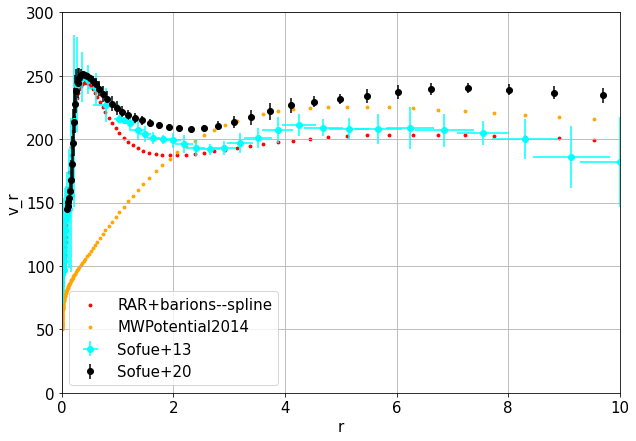

In [3]:
# Rotation velocity
import accelerations_combine as acco

def grad_mw(x,y,z):
    return -acco.accel_mw(x,y,z)

def rot_vel_mw(r):
    return np.sqrt(r*(grad_mw(r,0,0)[0]))

def galpy_vcirc(r):
    mwp = MWPotential2014
    a= mwp[0].vcirc(r*u.kpc)
    b= mwp[1].vcirc(r*u.kpc)
    c= mwp[2].vcirc(r*u.kpc)
    return np.sqrt(a*a+b*b+c*c)

exec(open("./vel_Sofue13.py").read())
v_Sof20=pd.read_csv('vel_Sofue20.txt', sep=" ")
print(v_Sof20)

#Plot
r_vec=np.logspace(-3,3,200)
v_vec = [rot_vel_mw(x) for x in r_vec]
v_galpy = [220*galpy_vcirc(x) for x in r_vec]
print('V_c(R_sun)=',rot_vel_mw(8.129))

#print('vel=',v_vec)

fig = plt.figure(figsize=(10,7))
font = {"size": 15}  
plt.rc('font', **font)
plt.scatter(r_vec,v_vec,s=8,marker='o', color='red', label='RAR+barions--spline')
plt.scatter(r_vec,v_galpy,s=8,marker='o', color='orange',label='MWPotential2014')
#plt.scatter(r_vec,v_vec2,s=1,marker='o', color='blue', label='RAR+barions--standard')
#plt.scatter(r_vec,v_vec3,s=0.4,marker='o', color='blue', label='RAR+barions--other params')
plt.errorbar(v_Sof['r']/1.e3, v_Sof['v'], xerr=v_Sof['err_r']/1.e3 ,yerr=v_Sof['err_v'], fmt='o', color='cyan', label='Sofue+13')
plt.errorbar(v_Sof20['Radius'],v_Sof20['Velocity'],yerr=v_Sof20['Error'],fmt='o',color='black',label='Sofue+20')
plt.xlim(0,10)
plt.ylim(0,300)
plt.xlabel('r')
plt.ylabel('v_r')
plt.grid(True)
plt.legend()
#plt.xscale('symlog')
plt.savefig('plots/rotation_curve.png')

/home/mmestre/work/2020/halostream/sources/stream_fit/fixed_pot/orbit_model/accelerations.py:150: RuntimeWarning: invalid value encountered in double_scalars
  return -np.array([dPhi_dR_spline(R,abs_z)[0][0]*x/R, dPhi_dR_spline(R,abs_z)[0][0]*y/R, np.sign(z)*dPhi_dz_spline(R,abs_z)[0][0]])
No handles with labels found to put in legend.


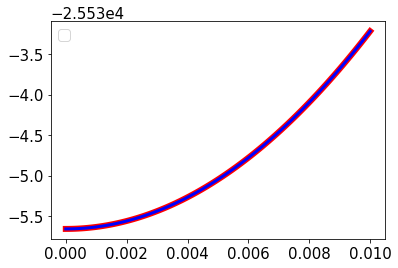

In [25]:
# Test computation of thin disk spline
import accelerations as ac


r=np.linspace(0,0.01,100)

accel_a=np.zeros(len(r))
accel_b=np.zeros(len(r))
for i in range(0,len(r)):
    x=np.array([r[i],0.,0.1])
    accel_a[i] = ac.accel_expon_flat_disk_spline(x[0],x[1],x[2])[2] 
    accel_b[i] = ac.accel_expon_flat_disk(cfg.sigma_efd,cfg.a_efd,x[0],x[1],x[2])[2]

#print(accel_a)
#print(accel_b)
#print((accel_a-accel_b)/accel_a)
plt.plot(r,accel_a,color='red',linewidth=6)
plt.plot(r,accel_b,color='blue',linewidth=3)
plt.legend()
